In [1]:
import numpy as np
import sympy as sp
import scipy.sparse as sparse

import ipywidgets as widgets
# pip install ipywidgets

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib notebook

#from IPython.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

x, y, t = sp.symbols('x,y,t')

In [2]:
def mesh2D(N, L, sparse=False):
    x = np.linspace(0, L, N+1)
    y = np.linspace(0, L, N+1)
    return np.meshgrid(x, y, indexing='ij', sparse=sparse)

def D2(N):
    D = sparse.diags([1, -2, 1], [-1, 0, 1], (N+1, N+1), 'lil')
    D[0, :4] = 2, -5, 4, -1
    D[-1, -4:] = -1, 4, -5, 2
    return D

In [3]:
def solver_exact(N, L, Nt, mx, my, cfl=0.5, c=1):
    w = c * np.sqrt(mx**2 + my**2)
    ue = sp.sin(mx * sp.pi * x) * sp.sin(my * sp.pi * y) * sp.cos(w * t)

    dx = L / N
    dt = cfl*dx/c
    xij, yij = mesh2D(N, L)
    
    data = {}
    for time_step in range(0,Nt):
        u_exact = sp.lambdify((x, y, t), ue)(xij, yij, time_step * dt)
        data[time_step] = u_exact.copy()
    return data

In [4]:
#copied from lecture 7
def solver(N, L, Nt, mx, my, cfl=0.5, c=1, store_data=10):
    w = c * np.sqrt(mx**2 + my**2)
    ue = sp.sin(mx * sp.pi * x) * sp.sin(my * sp.pi * y) * sp.cos(w * t)

    dx = L/N
    dt = cfl*dx/c
    xij, yij = mesh2D(N, L)
    D = D2(N)/dx**2

    # initial conditions:
    Unp1, Un, Unm1 = np.zeros((3, N+1, N+1))
    # initial impulse, w is 0
    t0=0
    Unm1 = sp.lambdify((x, y, t), ue)(xij, yij, t0)
   
    Un[:] = Unm1[:] + 0.5*(c*dt)**2*(D @ Un + Un @ D.T)
    plotdata = {0: Unm1.copy()}
    for n in range(1, Nt):
        Unp1[:] = 2*Un - Unm1 + (c*dt)**2*(D @ Un + Un @ D.T)
        # Set boundary conditions
        Unp1[0] = 0
        Unp1[-1] = 0
        Unp1[:, -1] = 0
        Unp1[:, 0] = 0
        # Swap solutions
        Unm1[:] = Un
        Un[:] = Unp1
        if n % store_data == 0:
            plotdata[n] = Unm1.copy() # Unm1 is now swapped to Un
    return xij, yij, plotdata

In [5]:
N = 40; L = 1; Nt = 40; mx = 3; my = 3; cfl = 0.1
data_exact =          solver_exact(N, L, Nt, mx, my, cfl, c=1)
xij, yij, data_dirichlet =   solver(N, L, Nt, mx, my, cfl, c=1, store_data=1)

In [6]:
min_z_exact = np.amin(np.concatenate(list(data_exact.values())))
max_z_exact = np.amax(np.concatenate(list(data_exact.values())))
min_z_dirchlet = np.amin(np.concatenate(list(data_dirichlet.values())))
max_z_dirchlet = np.amax(np.concatenate(list(data_dirichlet.values())))
min_z_total = np.amin([min_z_exact, min_z_dirchlet])
max_z_total = np.amin([max_z_exact, max_z_dirchlet])
"exact z range:", min_z_exact, min_z_dirchlet, "numerical z range", max_z_exact, max_z_dirchlet

('exact z range:',
 -0.996917333733128,
 -0.996917333733128,
 'numerical z range',
 1.0,
 1.0)

<IPython.core.display.Javascript object>


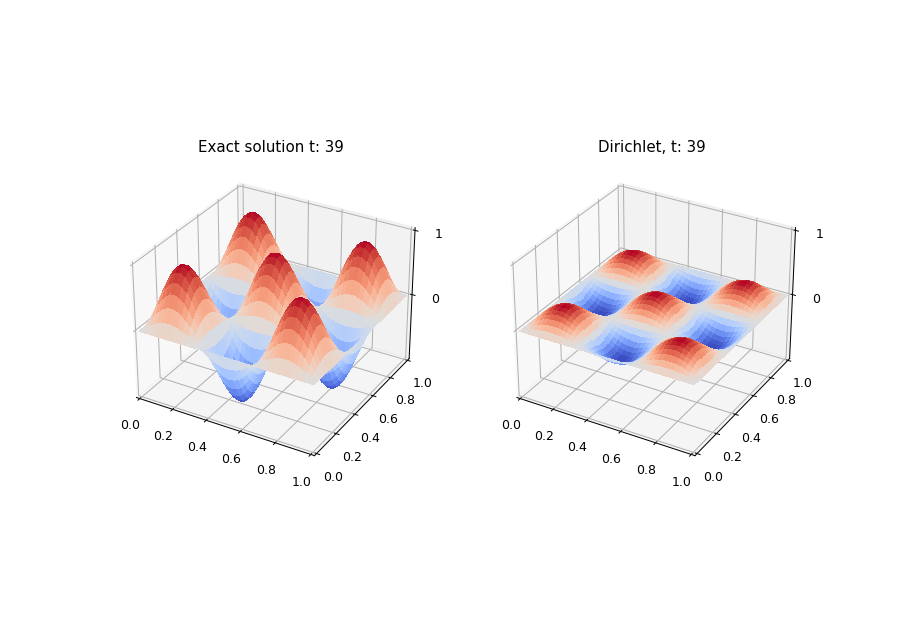

interactive(children=(IntSlider(value=0, description='frame', max=39), Output()), _dom_classes=('widget-intera…

In [11]:
from matplotlib.ticker import MaxNLocator
fig = plt.figure(figsize=(10, 7))

ax_exact = fig.add_subplot(121, projection='3d')
ax_exact.set_xlim(0, xij.max())
ax_exact.set_ylim(0, yij.max())
ax_exact.zaxis.set_major_locator(MaxNLocator(integer=True, nbins=8)) 
ax_exact.set_zlim(min_z_total, max_z_total)
ax_exact.set_title("Exact solution")


ax_dirichlet = fig.add_subplot(122, projection='3d')
#ax_dirichlet = fig.add_subplot(111, projection='3d')
ax_dirichlet.set_xlim(0, xij.max())
ax_dirichlet.set_ylim(0, yij.max())
ax_dirichlet.set_zlim(min_z_total, max_z_total)
ax_dirichlet.zaxis.set_major_locator(MaxNLocator(integer=True, nbins=8))
ax_dirichlet.set_title("Dirichlet")

surf_exact = ax_exact.plot_surface(xij, yij, data_exact[0], cmap=cm.coolwarm, linewidth=0, antialiased=False)
surf_dirichlet = ax_dirichlet.plot_surface(xij, yij, data_dirichlet[0], cmap=cm.coolwarm, linewidth=0, antialiased=False)

def update_plot(frame=0):
    global surf_exact; global surf_dirichlet
    surf_exact.remove(); surf_dirichlet.remove()
    surf_exact = ax_exact.plot_surface(xij, yij, data_exact[frame], cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax_exact.set_title(f"Exact solution t: {frame}")
    surf_dirichlet = ax_dirichlet.plot_surface(xij, yij, data_dirichlet[frame], cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax_dirichlet.set_title(f"Dirichlet, t: {frame}");

    
_= widgets.interact(update_plot, frame=widgets.IntSlider(min=0, max=len(data_exact)-1, step=1, value=0))